In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)

### Data

In [29]:
data = pd.read_csv('Datasets/Auto_MPG_data.csv')
data

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
...,...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
389,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1


In [30]:
X = data.drop(columns = 'MPG').values
y = data[['MPG']].values.squeeze()

X.shape, y.shape

((392, 9), (392,))

### Split data

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3333333, random_state=42, shuffle=True)

print(f'Number of training samples: {len(y_train)}')
print(f'Number of validation samples: {len(y_val)}')
print(f'Number of test samples: {len(y_test)}')

Number of training samples: 274
Number of validation samples: 78
Number of test samples: 40


### Normalization

In [82]:
# We only use the train set to fit the scaler
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

X_val = scaler.transform(X_val)

X_train.shape, X_test.shape, X_val.shape
X_train[0]

array([-0.87326597, -0.85486343, -0.28591285, -0.72540295,  0.34274942,
       -0.86872055, -0.41344912,  1.951158  , -1.35083021])

In [83]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

### Dataset

In [84]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        
        return (self.X[index], self.y[index])
    

In [85]:
dataset_train = CustomDataset(X_train, y_train)
dataset_val = CustomDataset(X_val, y_val)
dataset_test = CustomDataset(X_test, y_test)

### Data Loader

In [86]:
Batch_Size = 64
dataloader_train = DataLoader(dataset_train, batch_size=Batch_Size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=Batch_Size, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=Batch_Size, shuffle=False)

In [87]:
Sample_X = next(iter(dataloader_train))[0]
Sample_y = next(iter(dataloader_train))[1]
Sample_X.shape, Sample_y.shape

(torch.Size([64, 9]), torch.Size([64]))

### Model

In [121]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.block1 = nn.Linear(input_size, hidden_size)
        self.block2 = nn.Linear(hidden_size, output_size)

        self.tanh = nn.Tanh()
        #self.leakyrelu = nn.LeakyReLU()

    def forward(self, X):
        z1 = self.block1(X)

        a1 = self.tanh(z1)

        z2 = self.block2(a1)

        return z2



In [ ]:
input_size = X.shape[1]
hidden_size = 10
output_size = 1

model = NeuralNetwork(input_size, hidden_size, output_size)

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

def R_squared(y_true, y_pred):
    mean_y_true = np.mean(y_true)
    SST = np.sum((y_true - mean_y_true)**2)
    SSR = np.sum((y_true - y_pred)**2)
    return 1 - (SSR / SST)


In [138]:
epochs = 150
train_losses = []
val_losses = []
val_r2 = []
train_r2 = []

In [139]:
for X_train, y_train in dataloader_train:
        # Forward pass
        z = model(X_train).squeeze().tolist()
        print(z)
        break

[0.027177870273590088, -0.4738985300064087, -0.27791082859039307, 0.19685497879981995, -0.46642008423805237, -0.15548177063465118, -0.22191748023033142, -0.4790540933609009, -0.28786107897758484, -0.4245610237121582, -0.0689937025308609, 0.04996541142463684, -0.39709919691085815, 0.02137017250061035, -0.5204267501831055, -0.009423524141311646, -0.02698338031768799, -0.11171144247055054, -0.5398992300033569, -0.740456223487854, -0.13215653598308563, -0.31317394971847534, -0.678380012512207, -0.043747901916503906, -0.5866440534591675, 0.11273667216300964, -0.6994811296463013, 0.08276572823524475, -0.3445158004760742, 0.19083112478256226, 0.006045669317245483, -0.005112648010253906, -0.22505423426628113, -0.6126849055290222, 0.019092172384262085, -0.4059056341648102, -0.341457724571228, 0.15291959047317505, -0.3307183086872101, -0.32568860054016113, -0.148427814245224, -0.07157436013221741, -0.2866564989089966, -0.32756534218788147, 0.10167589783668518, -0.41448986530303955, -0.0905686542

In [140]:
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []

    model.train()
    for X_train, y_train in dataloader_train:
        
        # Forward pass
        z = model(X_train).squeeze()
        train_predict += z.tolist()
        train_target += y_train.tolist()

        loss_train = loss_fn(z, y_train)
        train_loss += loss_train.item()


        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

    train_loss = train_loss / len(dataloader_train)

    train_losses.append(train_loss)

    r2_score = R_squared(np.array(train_target), np.array(train_predict))

    train_r2.append(r2_score)

    model.eval()
    with torch.no_grad():
        for X_val, y_val in dataloader_val:
            # Forward pass
            z_val = model(X_val).squeeze()
            val_predict += z_val.tolist()
            val_target += y_val.tolist()

            loss_val = loss_fn(z_val, y_val)
            val_loss += loss_val.item()

        val_loss = val_loss / len(dataloader_val)

        val_losses.append(val_loss)

        r2_score_val = R_squared(np.array(val_target), np.array(val_predict))
        val_r2.append(r2_score_val)


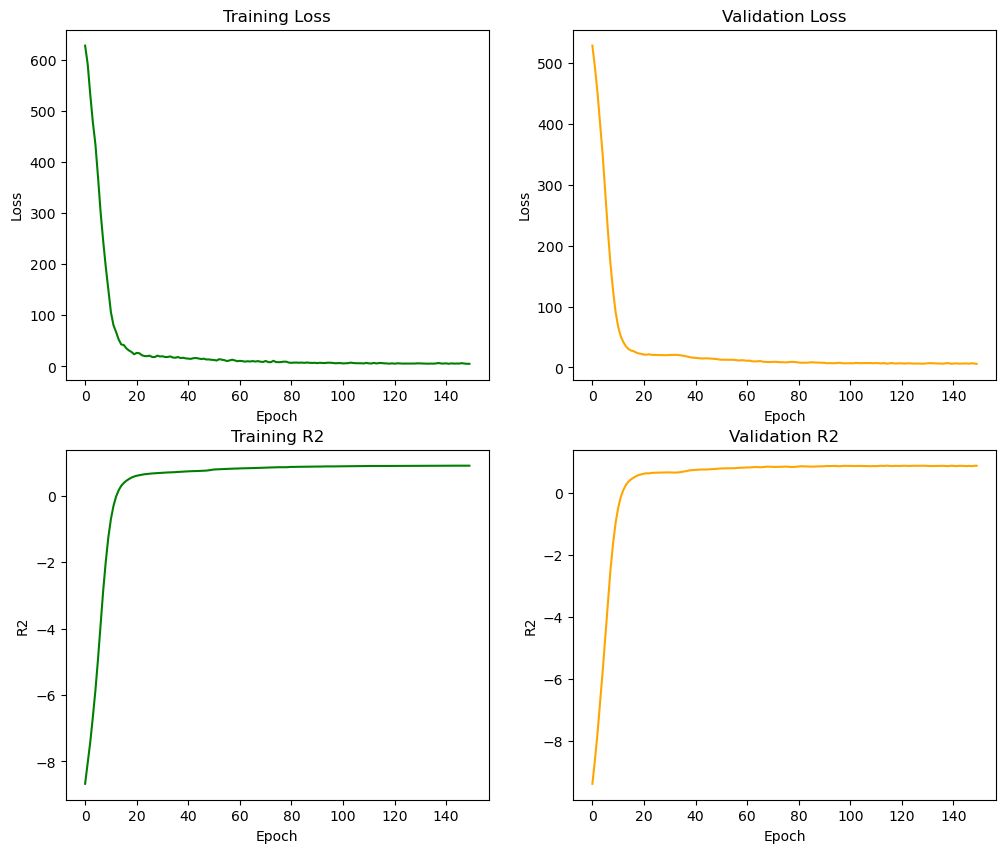

In [141]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_r2, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='R2')
ax[1, 0].set_title('Training R2')

ax[1, 1].plot(val_r2, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='R2')
ax[1, 1].set_title('Validation R2')

plt.show()


### Evaluation

In [145]:
model.eval()
with torch.no_grad():
    for X_test, y_test in dataloader_test:
        test_predict = []
        test_target = []
        test_loss = 0
        # Forward pass
        z_test = model(X_test).squeeze()
        test_predict += z_test.tolist()
        test_target += y_test.tolist()

        loss_test = loss_fn(z_test, y_test)
        test_loss += loss_test.item()

    test_loss = test_loss / len(dataloader_test)

    r2_score_test = R_squared(np.array(test_target), np.array(test_predict))

    print(f'Test Loss: {test_loss:.4f}, R² Score: {r2_score_test:.4f}')

Test Loss: 6.5722, R² Score: 0.8441
